Analysis of Enron Data. Based on Udacity intro to machine learning course

email data can be found at: https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tgz
financial data can be found in 'financial_data.pdf' in this repository

In [5]:
# Suppress package warnings, most of which are caused by deprecations
import warnings
warnings.filterwarnings('ignore')

In [6]:
### Load the dictionary containing financial data and some email features (to_ from_poi)
import pickle
with open('data/final_project_dataset.pkl', 'rb') as f:
    fin_data_dict = pickle.load(f)

# Remove outliers
fin_data_dict.pop('TOTAL', 0)

# Store to my_dataset for easy export below.
my_dataset = fin_data_dict


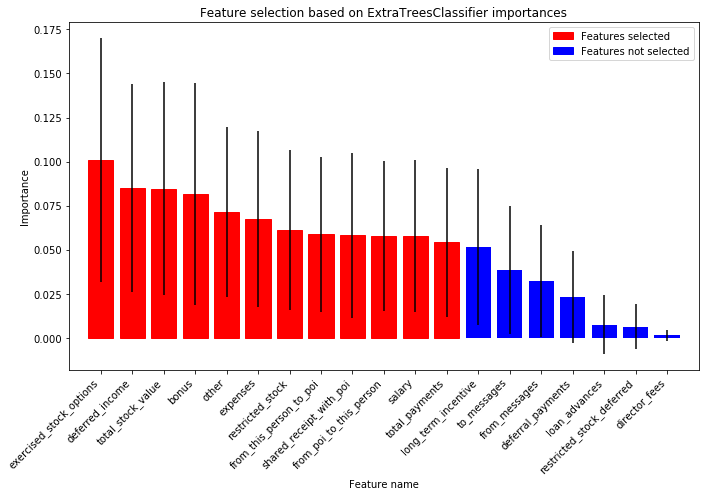

In [8]:
### Select features to use

# features_list is a list of feature names in the financial data.
# The first feature must be "poi".

import numpy as np
from tools.feature_format import featureFormat, targetFeatureSplit

def make_features_labels(dataset, feature_names):
    """
    Quick way to split a dataset into features and labels based on feature names
    """
    data = featureFormat(dataset, feature_names, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    labels = np.array(labels)
    features = np.array(features)
    
    return features, labels

# Start with all features except: 'email_address'

all_feature_names = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',\
'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi',\
'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances',\
'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income',\
'long_term_incentive', 'from_poi_to_this_person']

all_features, all_labels = make_features_labels(my_dataset, all_feature_names)

# Select the most important features based on ExtraTreesClassifier
from feature_selection import importance_plotter
selected_feature_names = importance_plotter(all_features, all_labels, 
                                            np.array(all_feature_names[1:]))

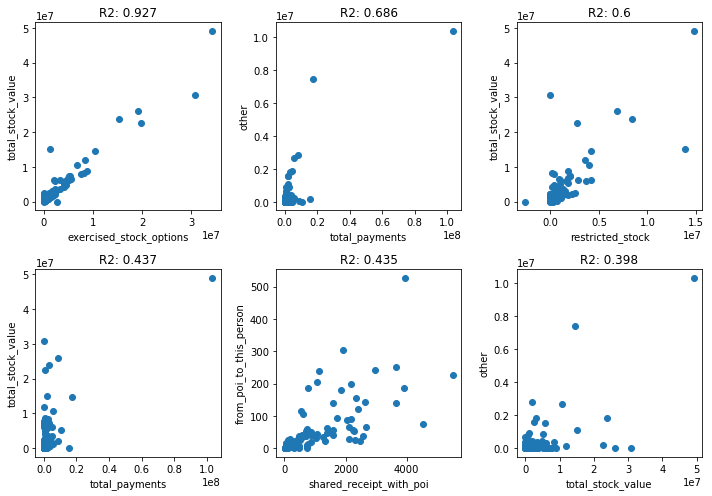

In [9]:
# Plot the most highly correlated features to see if there is any redundancy or outliers 
from feature_selection import correlation_plotter
correlation_plotter(selected_feature_names, my_dataset)

In [10]:
# From the correlation graphs it seems like total_stock_value correlates with a lot
# of other features and is very similar to exercised_stock_options, so I will remove it.
selected_feature_names.remove('total_stock_value')

In [11]:
### Confirm that the feature selection did help performance:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics

# Make features and labels based on the new selection
selected_feature_names.insert(0, 'poi')
selected_features, selected_labels = make_features_labels(my_dataset, selected_feature_names)

clf = GaussianNB()
def fit_print_scores(clf, features, labels):

    f1_scores = cross_val_score(clf, features, labels, cv=5, scoring='f1')
    print '-f1 score: %0.2f (+/- %0.2f)' % (f1_scores.mean(), 
                                           f1_scores.std() * 2)
    precision_scores = cross_val_score(clf, features, labels, cv=5, scoring='precision')
    print '-precision score: %0.2f (+/- %0.2f)' % (precision_scores.mean(), 
                                                  precision_scores.std() * 2)
    recall_scores = cross_val_score(clf, features, labels, cv=5, scoring='recall')
    print '-recall score: %0.2f (+/- %0.2f)' % (recall_scores.mean(), 
                                                  recall_scores.std() * 2)

print 'All features:'
fit_print_scores(clf, all_features, all_labels)
print '\nSelected features:'
fit_print_scores(clf, selected_features, selected_labels)

All features:
-f1 score: 0.24 (+/- 0.27)
-precision score: 0.19 (+/- 0.24)
-recall score: 0.42 (+/- 0.52)

Selected features:
-f1 score: 0.30 (+/- 0.34)
-precision score: 0.32 (+/- 0.37)
-recall score: 0.28 (+/- 0.33)


In [2]:
### Create new features
import pickle
from email_analysis import email_list_and_labels

with open('data/word_dict_subset.pkl', 'rb') as f:
    data_text = pickle.load(f)

#test = {key:data_text[key] for key in list(data_text.keys()[:3])}
all_emails, all_email_labels = email_list_and_labels(data_text, 'all')

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)
feature_matrix = vectorizer.fit_transform(all_emails)

In [13]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
fit_print_scores(clf, feature_matrix.toarray(), all_email_labels)

-f1 score: 0.00 (+/- 0.00)
-precision score: 0.00 (+/- 0.00)
-recall score: 0.00 (+/- 0.00)


Looks like email word extraction does not yield very promising results, will drop for now.

In [ ]:
### Try a variety of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()


In [ ]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

from sklearn.metrics import classification_report
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print classification_report(labels_test, pred)

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
from tools.tester import dump_classifier_and_data

dump_classifier_and_data(clf, my_dataset, features_list)